<img src="https://github.com/big-inpe/cap-423/blob/main/docs-site/images/cap.png?raw=true" align="right" width="120"/>


<div style="text-align: center;">
    <span style="justify-content: center;color:#336699;">
      <h2> Object-based and pixel-based time series classification for land use and cover mapping in Petrolina-PE </h2>
    </span>
</div>
<hr style="border:2px solid #0077b9;">

<div style="text-align: center;font-size: 90%;">
    Pedro Brito and Felipe Carvalho
    <br/><br/>
    Graduate Program in Applied Computing - INPE/CAP 
    <br/>
    Avenida dos Astronautas, 1758, Jardim da Granja, São José dos Campos, SP 12227-010, Brazil
    <br/><br/>
    Contact: <a href="mailto:pedrobritoufrpe@gmail.com">pedrobritoufrpe@gmail.com</a>, <a href="mailto:lipecaso@gmail.com">lipecaso@gmail.com</a>
</div>

<br/>

<div style="text-align: justify;  margin-left: 25%; margin-right: 25%;">
<b>Abstract.</b> This notebook compared two classification approaches, pixel-based and object-based. The comparison was made using validation points.
</div>

## <span style="color:#336699">Import packages</span>

<hr style="border:1px solid #0077b9;">

In [5]:
#
# Import SITS package to produce classifications
#
library(sits)

#
# Import terra package to work with raster data
#
library(terra)

#
# Import sf package to work with vector data
#
library(sf)

#
# Set seed to ensure reproducibility
#
set.seed(123)

## <span style="color:#336699">Create data cube</span>

<hr style="border:1px solid #0077b9;">

In [2]:
#
# Cube directory
#
cube_dir <- "../data/output/PE/cube/"

#
# Cube bands
#
cube_bands <- c(
  "B02", "B03", "B04", "B08", "B11", "B12", "B8A", "EVI", "NDVI", "CLOUD"
)

#
# Total of workers available
#
multicores <- 24

#
# Create cube directory
#
dir.create(cube_dir, recursive = TRUE, showWarnings = FALSE)

#
# 2. Define working tiles
#
tile <- c("035015", "036015", "036016")

#
# Define dates
#
start_date <- paste0("2021-10-16")
end_date <- paste0("2022-09-30")

#
# Create Sentinel-2 data cube
#
cube <- sits_cube(
    source     = "BDC",
    collection = "SENTINEL-2-16D",
    tiles      = tile,
    start_date = start_date,
    end_date   = end_date,
    bands      = cube_bands
)

Warning message in dir.create(cube_dir, recursive = TRUE):
“'../data/output/PE/cube' already exists”


  |======================================================================| 100%


In [4]:
print(cube)

# A tibble: 3 × 12
  source collection     satellite sensor tile    xmin   xmax   ymin   ymax crs  
  <chr>  <chr>          <chr>     <chr>  <chr>  <dbl>  <dbl>  <dbl>  <dbl> <chr>
1 BDC    SENTINEL-2-16D SENTINEL… MSI    0350… 6.32e6 6.43e6 1.03e7 1.04e7 "PRO…
2 BDC    SENTINEL-2-16D SENTINEL… MSI    0360… 6.43e6 6.53e6 1.03e7 1.04e7 "PRO…
3 BDC    SENTINEL-2-16D SENTINEL… MSI    0360… 6.43e6 6.53e6 1.02e7 1.03e7 "PRO…
# ℹ 2 more variables: labels <list>, file_info <list>


### Reading Samples

In [5]:
#
# General definition
#

# Samples
samples_file <- "../data/output/PE/time_series/clean_samples_2019_2020_band.rds"

# Output directory
base_output_dir <- "../data/output/PE"

#
# 1. Load samples
#
samples <- readRDS(samples_file)

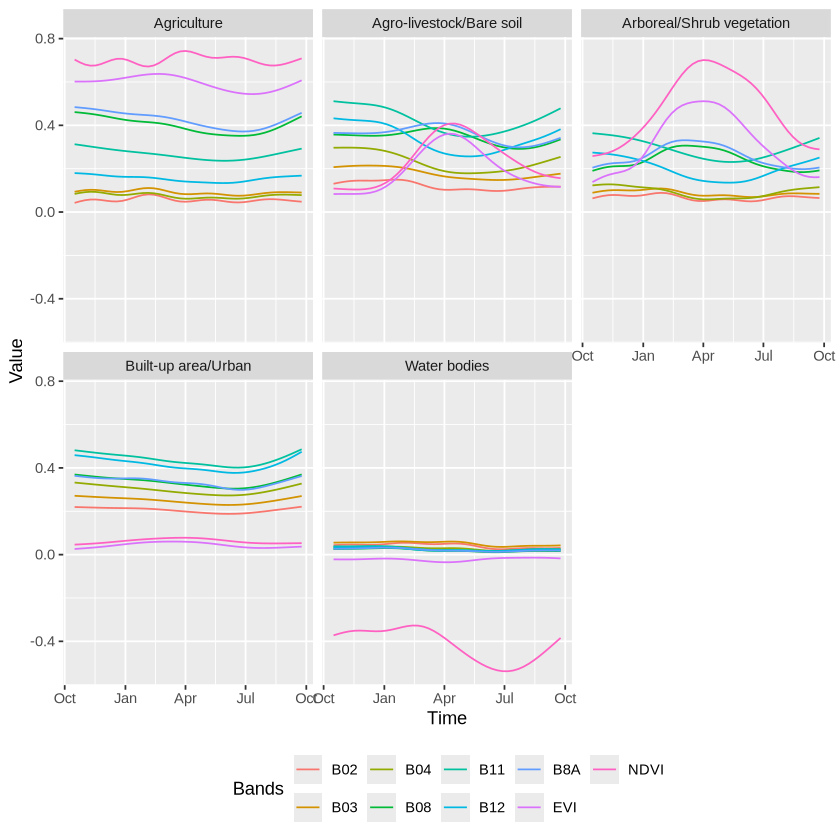

In [6]:
plot(sits_patterns(samples))

### Tunning CNN

In [7]:
#
# 2. Train model
#
tuned_tempcnn <- sits_tuning(
  samples   = samples,
  ml_method = sits_tempcnn(),
  params        = sits_tuning_hparams(
    optimizer   = torch::optim_adamw,
    cnn_kernels = choice(c(3, 3, 3), c(5, 5, 5), c(7, 7, 7)),
    cnn_layers  = choice(c(2^5, 2^5, 2^5), c(2^6, 2^6, 2^6), c(2^7, 2^7, 2^7)),
    opt_hparams = list(
            lr = loguniform(10^-2, 10^-4)
        )
  ),
  trials     = 50,
  multicores = 20,
  progress   = TRUE
)

  |======================================================================| 100%


In [8]:
print(tuned_tempcnn)

# A tibble: 50 × 19
   accuracy kappa acc        samples_validation cnn_layers       cnn_kernels
      <dbl> <dbl> <list>     <list>             <chr>            <chr>      
 1    0.989 0.986 <cnfsnMtr> <NULL>             c(2^6, 2^6, 2^6) c(7, 7, 7) 
 2    0.989 0.986 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(3, 3, 3) 
 3    0.989 0.986 <cnfsnMtr> <NULL>             c(2^5, 2^5, 2^5) c(7, 7, 7) 
 4    0.984 0.979 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(3, 3, 3) 
 5    0.984 0.979 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(5, 5, 5) 
 6    0.984 0.979 <cnfsnMtr> <NULL>             c(2^6, 2^6, 2^6) c(7, 7, 7) 
 7    0.978 0.972 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(3, 3, 3) 
 8    0.978 0.972 <cnfsnMtr> <NULL>             c(2^5, 2^5, 2^5) c(7, 7, 7) 
 9    0.978 0.972 <cnfsnMtr> <NULL>             c(2^5, 2^5, 2^5) c(5, 5, 5) 
10    0.978 0.972 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(5, 5, 5) 
# ℹ 40 more rows
# ℹ 13 more variables: cnn_dropout_rate

In [10]:
# tuned directory
tuning_dir <- "../data/output/PE/tune/tempcnn/"
dir.create(tuning_dir, recursive = TRUE)

saveRDS(tuned_tempcnn, paste0(tuning_dir, "tempcnn_pe.rds"))

Warning message in dir.create(tuning_dir, recursive = TRUE):
“'../data/output/PE/tune/tempcnn' already exists”


In [11]:
tuned_tempcnn <- readRDS("../data/output/PE/tune/tempcnn/tempcnn_pe.rds")

### Training CNN

In [13]:
tcnn_model <- sits_train(
    samples, sits_tempcnn(
          cnn_layers = c(2^6, 2^6, 2^6),
          cnn_kernels = c(7, 7, 7),
          cnn_dropout_rates = c(0.2, 0.2, 0.2),
          dense_layer_nodes = 256,
          dense_layer_dropout_rate = 0.5,
          epochs = 150,
          batch_size = 64,
          optimizer = torch::optim_adamw,
          opt_hparams = list(lr = 0.0003105814),
          patience = 20,
          min_delta = 0.01,
          verbose = FALSE
    )
)

In [14]:
environment(tcnn_model)$torch_model

A `luz_module_fitted`
── Time ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
• Total time: 8.6s
• Avg time per training epoch: 219ms

── Results ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Metrics observed in the last epoch.

ℹ Training:
loss: 0.0584
acc: 0.9872

── Model ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
An `nn_module` containing 440,837 parameters.

── Modules ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
• conv_bn_relu1: <conv1D_batch_norm

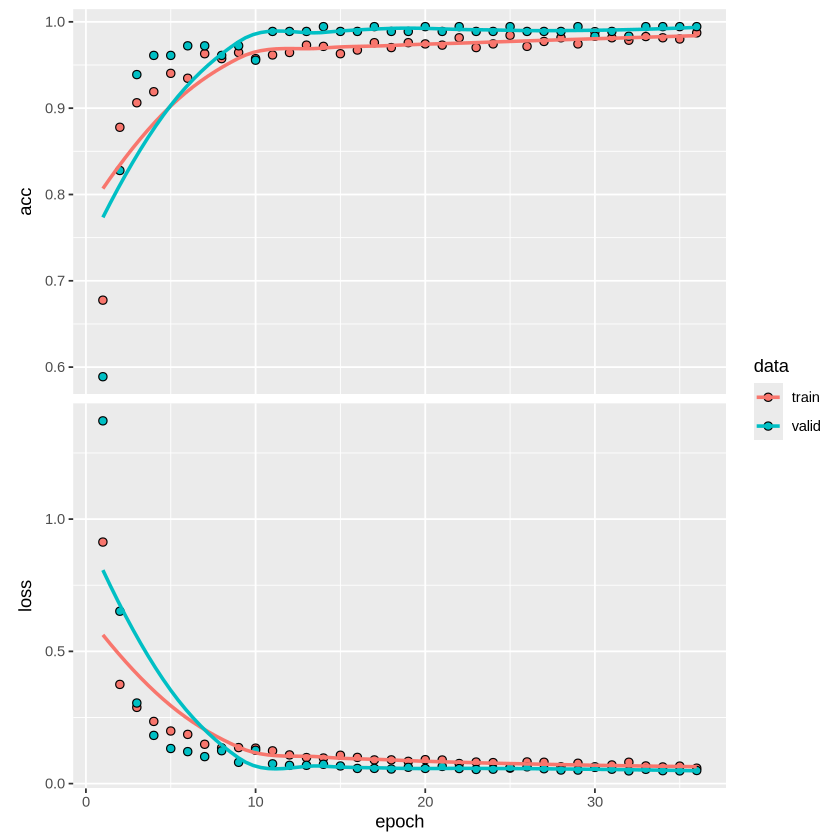

In [15]:
plot(tcnn_model)

In [16]:
#
# 3. Save model
#

base_model_dir <- "../data/output/PE/model/"

tcnn_dir <- paste0(base_model_dir, "tcnn_model.rds")  

# create directory
dir.create(base_model_dir, recursive = TRUE)

# save
saveRDS(tcnn_model, tcnn_dir)

In [13]:
tcnn_model <- readRDS("../data/output/PE/model/tcnn_model.rds")

### Tuning LightTAE

In [21]:
tuned_lighttae <- sits_tuning(
  samples   = samples,
  ml_method = sits_lighttae(),
  params        = sits_tuning_hparams(
    optimizer   = torch::optim_adamw,
    opt_hparams = list(
      lr           = loguniform(10^-2, 10^-4),
      weight_decay = loguniform(10^-2, 10^-8)
    )
  ),
  trials     = 50,
  multicores = 10,
  progress   = TRUE
)

  |======================================================================| 100%


In [22]:
# tuned directory
tuning_dir <- "../data/output/PE/tune/lighttae/"
dir.create(tuning_dir, recursive = TRUE)

saveRDS(tuned_lighttae, paste0(tuning_dir, "lighttae_pe.rds"))

In [23]:
tuned_lighttae <- readRDS("../data/output/PE/tune/lighttae/lighttae_pe.rds")

In [24]:
print(tuned_lighttae[1,]$opt_hparams)

[[1]]
# A tibble: 1 × 2
        lr weight_decay
     <dbl>        <dbl>
1 0.000273      0.00161



### Training LightTAE

In [25]:
lighttae_model <- sits_train(
    samples, sits_lighttae(
      epochs = 150,
      batch_size = 128,
      optimizer = torch::optim_adamw,
      opt_hparams = list(lr = 0.000273, weight_decay = 0.00161),
      lr_decay_epochs = 50L,
      patience = 20L,
      min_delta = 0.01,
      verbose = FALSE
    )
)

In [32]:
environment(lighttae_model)$torch_model

A `luz_module_fitted`
── Time ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
• Total time: 1m 29.8s
• Avg time per training epoch: 1.5s

── Results ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Metrics observed in the last epoch.

ℹ Training:
loss: 0.1252
acc: 0.9643

── Model ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
An `nn_module` containing 127,867 parameters.

── Modules ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
• spatial_encoder: <torch_pixel_

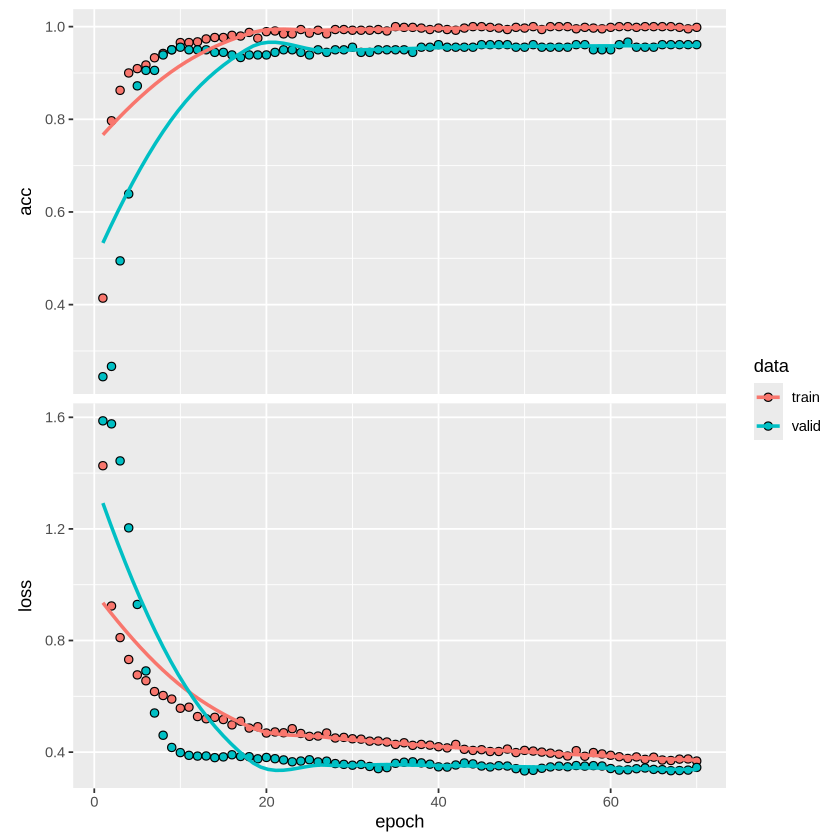

In [26]:
plot(lighttae_model)

In [27]:
#
# 3. Save model
#

ltae_dir <- paste0(base_model_dir, "ltae_model.rds")  

# save
saveRDS(lighttae_model, ltae_dir)

In [12]:
lighttae_model <- readRDS("../data/output/PE/model/ltae_model.rds")

### Pixel-based classification - TCNN

In [40]:
# Output directory
output_dir <- "../data/output/PE/classifications/tccn"

# Version
results_version <- "tcnn-8cls"

#
# 1. Create directory
#
dir.create(output_dir, recursive = TRUE)

#
# 4. Classify
#

# classify
probs_cube <- sits_classify(
    data       = cube,
    ml_model   = tcnn_model,
    memsize    = 54,
    gpu_memory = 10,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version,
    progress   = TRUE,
    verbose    = TRUE
)

# smooth
probs_bayes <- sits_smooth(
    cube           = probs_cube,
    window_size    = 9,
    neigh_fraction = 0.5,
    memsize        = 60,
    multicores     = 24,
    output_dir     = output_dir,
    version        = results_version
)

# generate map
class_cube <- sits_label_classification(
    cube       = probs_bayes,
    memsize    = 60,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version
)

Warning message in dir.create(output_dir, recursive = TRUE):
“'../data/output/PE/classifications/tccn' already exists”
using blocks of size 512 x 5632

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version



task finished at2024-12-04 12:24:07.299861

elapsed time for task0.05 secs



  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


### Pixel-based classification - LightTAE

In [44]:
# Output directory
output_dir <- "../data/output/PE/classifications/lighttae"

# Version
results_version <- "lighttaeb-8cls"

#
# 1. Create directory
#
dir.create(output_dir, recursive = TRUE)

#
# 4. Classify
#
probs_cube <- sits_classify(
    data       = cube,
    ml_model   = lighttae_model,
    memsize    = 54,
    gpu_memory = 10,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version,
    progress   = TRUE,
    verbose    = TRUE
)

# smooth
probs_bayes <- sits_smooth(
    cube           = probs_cube,
    window_size    = 9,
    neigh_fraction = 0.5,
    memsize        = 60,
    multicores     = 24,
    output_dir     = output_dir,
    version        = results_version
)

# generate map
class_cube <- sits_label_classification(
    cube       = probs_bayes,
    memsize    = 60,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version
)

Warning message in dir.create(output_dir, recursive = TRUE):
“'../data/output/PE/classifications/lighttae' already exists”
using blocks of size 512 x 5632

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version



task finished at2024-12-04 19:53:25.38606

elapsed time for task0.06 secs



  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


### Apply Spatial-temporal segmentation

In [5]:
segment_dir <- "../data/output/PE/segment/"
segments <- sits_segment(
  cube = cube,
  seg_fn = sits_slic(
    step = 20,
    compactness = 1,
    dist_fun = "euclidean",
    iter = 20,
    minarea = 20
  ),
  output_dir = segment_dir,
  memsize    = 30,
  multicores = 12
)

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version



In [6]:
roi <- sf::st_read("../data/output/PE/shape_petrolina/limite_petrolina.shp")

Reading layer `limite_petrolina' from data source 
  `/home/jovyan/experiment-geo-dl/data/output/PE/shape_petrolina/limite_petrolina.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 4 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -40.95904 ymin: -9.482897 xmax: -40.20811 ymax: -8.623499
Geodetic CRS:  SIRGAS 2000


### Object-based classification - TCNN

In [8]:
# Output directory
output_dir <- "../data/output/PE/segment/tcnn"

# Version
results_version <- "tcnn-8cls-segments"

#
# 1. Create directory
#
dir.create(output_dir, recursive = TRUE)

#
# 4. Classify
#
probs_cube <- sits_classify(
    data       = segments,
    ml_model   = tcnn_model,
    n_sam_pol  = 40,
    memsize    = 8,
    gpu_memory = 10,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version,
    roi        = roi,
    progress   = TRUE
)

# generate map
class_cube <- sits_label_classification(
    cube       = probs_cube,
    memsize    = 30,
    multicores = 12,
    output_dir = output_dir,
    version    = results_version
)

Warning message in dir.create(output_dir, recursive = TRUE):
“'../data/output/PE/segment/tcnn' already exists”


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


### Object-based classification - LightTae

In [7]:
# Output directory
output_dir <- "../data/output/PE/segment/ltae"

# Version
results_version <- "ltae-8cls-segments"

#
# 1. Create directory
#
dir.create(output_dir, recursive = TRUE)

#
# 4. Classify
#
probs_cube <- sits_classify(
    data       = segments,
    ml_model   = lighttae_model,
    n_sam_pol  = 40,
    memsize    = 8,
    gpu_memory = 10,
    multicores = 24,
    roi        = roi,
    output_dir = output_dir,
    version    = results_version,
    progress   = FALSE,
    verbose    = FALSE
)

# generate map
class_cube <- sits_label_classification(
    cube       = probs_cube,
    memsize    = 30,
    multicores = 12,
    output_dir = output_dir,
    version    = results_version
)

Warning message in dir.create(output_dir, recursive = TRUE):
“'../data/output/PE/segment/ltae' already exists”


In [147]:
sits_labels(lighttae_model)

[1] "Agriculture"               "Agro-livestock/Bare soil" 
[3] "Arboreal/Shrub vegetation" "Built-up area/Urban"      
[5] "Water bodies"

In [148]:
sits_labels(tcnn_model)

[1] "Agriculture"               "Agro-livestock/Bare soil" 
[3] "Arboreal/Shrub vegetation" "Built-up area/Urban"      
[5] "Water bodies"

### Validation

In [74]:
samples_val <- read.csv("../data/output/PE/samples/validation_samples/validation_samples_petrolina_2019_2020.csv")
roi <- sf::st_read("../data/output/PE/shape_petrolina/limite_petrolina.shp")
head(samples_val, n = 10)

Reading layer `limite_petrolina' from data source 
  `/home/jovyan/experiment-geo-dl/data/output/PE/shape_petrolina/limite_petrolina.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 4 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -40.95904 ymin: -9.482897 xmax: -40.20811 ymax: -8.623499
Geodetic CRS:  SIRGAS 2000


,id,longitude,latitude,start_date,end_date,label
,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,1,-40.42631,-9.257637,2019-10-01,2020-09-30,Agriculture
2,2,-40.49639,-9.300568,2019-10-01,2020-09-30,Agriculture
3,3,-40.51396,-9.155946,2019-10-01,2020-09-30,Agriculture
4,4,-40.51949,-9.255985,2019-10-01,2020-09-30,Agriculture
5,5,-40.35861,-9.354720,2019-10-01,2020-09-30,Agriculture
6,6,-40.56763,-9.383339,2019-10-01,2020-09-30,Agriculture
7,7,-40.41106,-9.295216,2019-10-01,2020-09-30,Agriculture
8,8,-40.53875,-9.346849,2019-10-01,2020-09-30,Agriculture
9,9,-40.67038,-9.303548,2019-10-01,2020-09-30,Agriculture


### Validation pixel-based - TCNN

In [14]:
labels <- sits_labels(tcnn_model)
names(labels) <- seq_len(length(labels))

In [56]:
class_tcnn <- sits_cube(
    source     = "BDC",
    collection = "SENTINEL-2-16D",
    data_dir   = "../data/output/PE/classifications/tccn/",
    bands      = "class",
    labels     = labels,
    version    = "tcnn-8cls"
)

  |======================================================================| 100%


In [58]:
mosaic_tcnn <- sits_mosaic(
    cube = class_tcnn,
    roi = roi,
    crs = "+proj=aea +lat_0=-12 +lon_0=-54 +lat_1=-2 +lat_2=-22 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +units=m +no_defs",
    multicores = 2,
    output_dir = "../data/output/PE/classifications/tccn/",
    version    = "tcnn-8cls"
)

  |======================================================================| 100%
  |======================================================================| 100%


In [59]:
acc_tcnn <- sits_accuracy(
    data = mosaic_tcnn,
    validation = samples_val,
    method = "pixel"
)

In [60]:
acc_tcnn

Confusion Matrix and Statistics

                           Reference
Prediction                  Agriculture Built-up area/Urban Water bodies
  Agriculture                        50                   0            0
  Built-up area/Urban                 0                  49            0
  Water bodies                        0                   0           50
  Agro-livestock/Bare soil            0                   1            0
  Arboreal/Shrub vegetation           0                   0            0
                           Reference
Prediction                  Agro-livestock/Bare soil Arboreal/Shrub vegetation
  Agriculture                                      0                         0
  Built-up area/Urban                             14                         0
  Water bodies                                     0                         0
  Agro-livestock/Bare soil                        13                         0
  Arboreal/Shrub vegetation                       23        

### Validation pixel-based - LightTAE

In [62]:
class_ltae <- sits_cube(
    source     = "BDC",
    collection = "SENTINEL-2-16D",
    data_dir   = "../data/output/PE/classifications/lighttae/",
    bands      = "class",
    labels     = labels,
    version    = "lighttaeb-8cls"
)

  |======================================================================| 100%


In [63]:
mosaic_ltae <- sits_mosaic(
    cube = class_ltae,
    roi = roi,
    crs = "+proj=aea +lat_0=-12 +lon_0=-54 +lat_1=-2 +lat_2=-22 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +units=m +no_defs",
    multicores = 2,
    output_dir = "../data/output/PE/classifications/lighttae/",
    version    = "lighttaeb-8cls"
)

  |======================================================================| 100%
  |======================================================================| 100%


In [64]:
acc_ltae <- sits_accuracy(
    data = mosaic_ltae,
    validation = samples_val,
    method = "pixel"
)

In [65]:
acc_ltae

Confusion Matrix and Statistics

                           Reference
Prediction                  Agriculture Built-up area/Urban Water bodies
  Agriculture                        50                   0            0
  Built-up area/Urban                 0                  44            0
  Water bodies                        0                   0           50
  Agro-livestock/Bare soil            0                   6            0
  Arboreal/Shrub vegetation           0                   0            0
                           Reference
Prediction                  Agro-livestock/Bare soil Arboreal/Shrub vegetation
  Agriculture                                      0                         0
  Built-up area/Urban                              2                         0
  Water bodies                                     0                         0
  Agro-livestock/Bare soil                        38                         0
  Arboreal/Shrub vegetation                       10        

### Validation object-based - TCNN

In [152]:
print(tiles_lst[[1]], n = 10)

Simple feature collection with 6726 features and 9 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 6411800 ymin: 10307870 xmax: 6425600 ymax: 10334070
Projected CRS: +proj=aea +lat_0=-12 +lon_0=-54 +lat_1=-2 +lat_2=-22 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +units=m +no_defs
First 10 features:
   supercells       x        y pol_id Agriculture Agro.livestock.Bare.soil
1        1387 6412035 10328765 241894  0.01498567              0.009858515
2        1373 6411975 10328175 243276  0.30270171              0.146507798
3        1375 6411995 10324415 243278  0.53717650              0.091968756
4        1378 6411995 10326535 243281  0.13352978              0.198645915
5        1380 6412025 10327915 243283  0.42186073              0.078373625
6        1381 6412015 10326715 243284  0.09295861              0.155028127
7        1382 6412005 10325355 243285  0.06704378              0.063670308
8        1383 6412025 10323805 243286  0.09276986              0.008977708
9       

In [149]:
tiles_to_mosaic <- list.files(
    "../data/output/PE/segment/tcnn/", 
    full.names = TRUE,
    pattern = "probs.*\\.gpkg"
)

tiles_lst <- lapply(tiles_to_mosaic, sf::st_read, quiet = FALSE)

tiles_vec <- dplyr::bind_rows(tiles_lst)

#rast_template <- terra::rast("../data/output/PE/classifications/tccn/SENTINEL-2_MSI_MOSAIC_2021-10-16_2022-09-30_class_tcnn-8cls.tif")

Reading layer `SENTINEL-2_MSI_035015_2021-10-16_2022-09-30_probs_tcnn-8cls-segments' from data source `/home/jovyan/experiment-geo-dl/data/output/PE/segment/tcnn/SENTINEL-2_MSI_035015_2021-10-16_2022-09-30_probs_tcnn-8cls-segments.gpkg' 
  using driver `GPKG'
Simple feature collection with 6726 features and 9 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 6411800 ymin: 10307870 xmax: 6425600 ymax: 10334070
Projected CRS: +proj=aea +lat_0=-12 +lon_0=-54 +lat_1=-2 +lat_2=-22 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +units=m +no_defs
Reading layer `SENTINEL-2_MSI_036015_2021-10-16_2022-09-30_probs_tcnn-8cls-segments' from data source `/home/jovyan/experiment-geo-dl/data/output/PE/segment/tcnn/SENTINEL-2_MSI_036015_2021-10-16_2022-09-30_probs_tcnn-8cls-segments.gpkg' 
  using driver `GPKG'
Simple feature collection with 127701 features and 9 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 6425600 ymin: 10264000 xmax: 6497650 ymax: 10349390
Projecte

In [68]:
tiles_vec <- tiles_vec |>
  dplyr::mutate(
    label_val = dplyr::case_when(
      class == "Agriculture" ~ 1,
      class == "Agro-livestock/Bare soil" ~ 2,
      class == "Arboreal/Shrub vegetation" ~ 3,
      class == "Built-up area/Urban" ~ 4,
      class == "Water bodies" ~ 5
    )
)

In [69]:
rasterize_cnn <- terra::rasterize(
    x = terra::vect(tiles_vec), 
    y = terra::rast(rast_template), 
    field = "label_val"
)

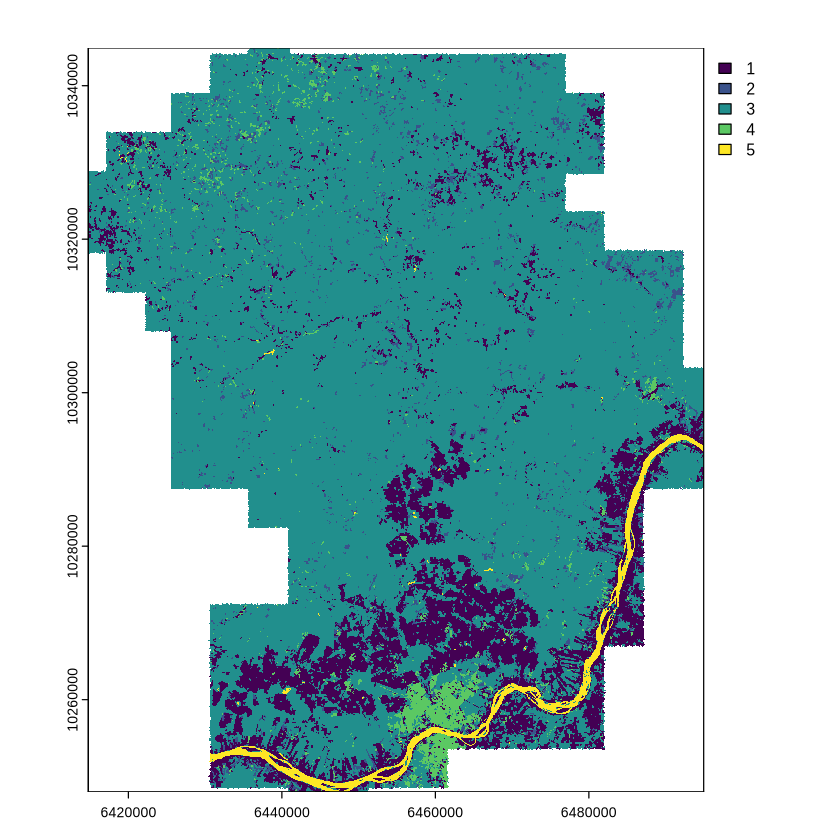

In [70]:
plot(rasterize_cnn)

In [71]:
terra::writeRaster(
    x = rasterize_cnn, 
    filename = "../data/output/PE/segment/tcnn/SENTINEL-2_MSI_MOSAIC_2021-10-16_2022-09-30_class_tcnn-8cls-segments-rasterize.tif",
    gdal = c("COMPRESS=LZW", "PREDICTOR=2", "BIGTIFF=YES",
             "TILED=YES", "BLOCKXSIZE=512", "BLOCKYSIZE=512"),
    datatype = "INT1U"
)

In [72]:
class_tcnn <- sits_cube(
    source     = "BDC",
    collection = "SENTINEL-2-16D",
    data_dir   = "../data/output/PE/segment/tcnn/",
    bands      = "class",
    labels     = labels,
    version    = "tcnn-8cls-segments-rasterize"
)

  |======================================================================| 100%


In [75]:
acc_tcnn <- sits_accuracy(
    data = class_tcnn,
    validation = samples_val,
    method = "pixel"
)

In [76]:
acc_tcnn

Confusion Matrix and Statistics

                           Reference
Prediction                  Agriculture Built-up area/Urban Water bodies
  Agriculture                        49                   0            0
  Built-up area/Urban                 0                  46            0
  Water bodies                        0                   0           50
  Agro-livestock/Bare soil            1                   2            0
  Arboreal/Shrub vegetation           0                   2            0
                           Reference
Prediction                  Agro-livestock/Bare soil Arboreal/Shrub vegetation
  Agriculture                                      0                         0
  Built-up area/Urban                              9                         0
  Water bodies                                     0                         0
  Agro-livestock/Bare soil                        23                         0
  Arboreal/Shrub vegetation                       18        

### Validation object-based - LTAE

In [168]:
tiles_to_mosaic <- list.files(
    "../data/output/PE/segment/ltae/", 
    full.names = TRUE,
    pattern = "class.*.gpkg"
)

tiles_lst <- lapply(tiles_to_mosaic, sf::st_read, quiet = FALSE)

tiles_vec <- dplyr::bind_rows(tiles_lst)

rast_template <- terra::rast("../data/output/PE/classifications/lighttae/SENTINEL-2_MSI_MOSAIC_2021-10-16_2022-09-30_class_lighttaeb-8cls.tif")

Reading layer `SENTINEL-2_MSI_035015_2021-10-16_2022-09-30_class_ltae-8cls-segments-new' from data source `/home/jovyan/experiment-geo-dl/data/output/PE/segment/ltae/SENTINEL-2_MSI_035015_2021-10-16_2022-09-30_class_ltae-8cls-segments-new.gpkg' 
  using driver `GPKG'
Simple feature collection with 34256 features and 10 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 6375990 ymin: 10307810 xmax: 6425600 ymax: 10334140
Projected CRS: +proj=aea +lat_0=-12 +lon_0=-54 +lat_1=-2 +lat_2=-22 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +units=m +no_defs
Reading layer `SENTINEL-2_MSI_036015_2021-10-16_2022-09-30_class_ltae-8cls-segments-new' from data source `/home/jovyan/experiment-geo-dl/data/output/PE/segment/ltae/SENTINEL-2_MSI_036015_2021-10-16_2022-09-30_class_ltae-8cls-segments-new.gpkg' 
  using driver `GPKG'
Simple feature collection with 198307 features and 10 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 6425600 ymin: 10264000 xmax: 6531200 ymax

In [169]:
tiles_vec <- tiles_vec |>
  dplyr::mutate(
    label_val = dplyr::case_when(
      class == "Agriculture" ~ 1,
      class == "Agro-livestock/Bare soil" ~ 2,
      class == "Arboreal/Shrub vegetation" ~ 3,
      class == "Built-up area/Urban" ~ 4,
      class == "Water bodies" ~ 5
    )
)

In [171]:
rasterize_ltae <- terra::rasterize(
    x = terra::vect(tiles_vec), 
    y = terra::rast(rast_template), 
    field = "label_val"
)

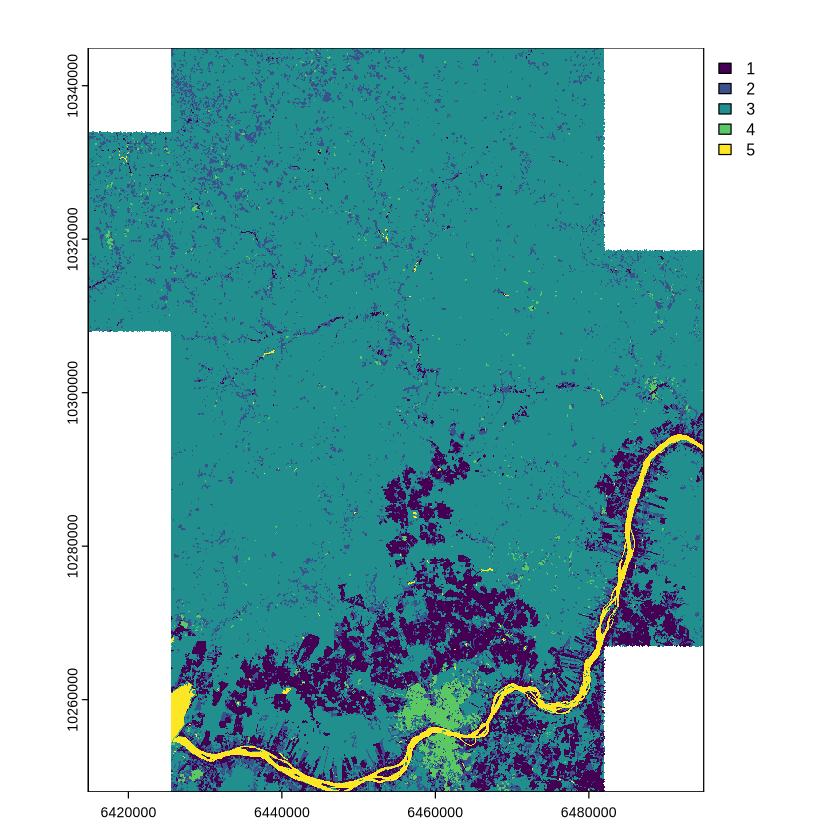

In [172]:
plot(rasterize_ltae)

In [181]:
terra::writeRaster(
    x = rasterize_ltae, 
    filename = "../data/output/PE/segment/ltae/SENTINEL-2_MSI_MOSAIC_2021-10-16_2022-09-30_class_lighttaeb-8cls-segments-rasterize.tif",
    gdal = c("COMPRESS=LZW", "PREDICTOR=2", "BIGTIFF=YES",
             "TILED=YES", "BLOCKXSIZE=512", "BLOCKYSIZE=512"),
    datatype = "INT1U"
)

In [182]:
class_ltae <- sits_cube(
    source     = "BDC",
    collection = "SENTINEL-2-16D",
    data_dir   = "../data/output/PE/segment/ltae/",
    bands      = "class",
    labels     = labels,
    version    = "lighttaeb-8cls-segments-rasterize"
)

  |======================================================================| 100%


In [183]:
acc_ltae <- sits_accuracy(
    data = class_ltae,
    validation = samples_val,
    method = "pixel"
)

In [184]:
acc_ltae

Confusion Matrix and Statistics

                           Reference
Prediction                  Agriculture Built-up area/Urban Water bodies
  Agriculture                        48                   0            0
  Built-up area/Urban                 0                  44            0
  Water bodies                        0                   0           50
  Agro-livestock/Bare soil            2                   6            0
  Arboreal/Shrub vegetation           0                   0            0
                           Reference
Prediction                  Agro-livestock/Bare soil Arboreal/Shrub vegetation
  Agriculture                                      0                         0
  Built-up area/Urban                              2                         0
  Water bodies                                     0                         0
  Agro-livestock/Bare soil                        35                         0
  Arboreal/Shrub vegetation                       13        